In [1]:
import stim
from blossom_5_binding import PerfectMatching as pmatch
import numpy as np
import sys
import multiprocessing
import time
import pickle
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt

In [2]:
class MomentDephaseAdder:
    def __init__(self, count, p1, p2, pm, pi):
        self.qubitstouched = np.ones(count)
        self.cx_list = []
        self.m_list = []
        self.i_list = []
        self.g1_list = []
        self.p1 = p1
        self.p2 = p2
        self.pm = pm
        self.pi = pi
    def touch(self, input):
        for n in input:
            self.qubitstouched[n] = 0
    def cx(self, x,y):
        self.cx_list.append([x,y])
        self.touch([x,y])
    def measure(self, q):
        self.m_list.append(q)
        self.touch([q])
    def init(self, q):
        self.i_list.append(q)
        self.touch([q])
    def g1(self, q):
        self.g1_list.append(q)
        self.touch([q])
    def get_error_circuit(self):
        c = stim.Circuit()
        for element in self.g1_list:
            c.append_operation("DEPOLARIZE1", [element], self.p1)
        for element in self.cx_list:
            c.append_operation("DEPOLARIZE2", element, self.p2)
        for element in self.m_list:
            c.append_operation("DEPOLARIZE1", [element], self.pm)
        for element in self.i_list:
            c.append_operation("DEPOLARIZE1", [element], self.pi)
        for i in range(self.qubitstouched.shape[0]):
            if self.qubitstouched[i] == 1:
                c.append_operation("DEPOLARIZE1", [i], self.p1)
        self.qubitstouched = np.ones(self.qubitstouched.shape)
        self.cx_list = []
        self.m_list = []
        self.i_list = []
        self.g1_list = []
        return c

In [3]:
class PlanarCode:
    def __init__(self, dx, dz, p1, p2, pm, pi):
        self.X_DISTANCE = dx
        self.Z_DISTANCE = dz
        self.LATTICE_X_DIMENSION = 2*dx - 1
        self.LATTICE_Z_DIMENSION = 2*dz - 1
        self.REQUIRED_QUBITS = self.LATTICE_X_DIMENSION*self.LATTICE_Z_DIMENSION
        self.REQUIRED_X_ANCS = dx*(dz - 1)
        self.REQUIRED_Z_ANCS = dz*(dx - 1)
        self.REQUIRED_ANCS = self.REQUIRED_X_ANCS + self.REQUIRED_Z_ANCS
        self.REQUIRED_DATA_QUBITS = dx*dz + (dx-1)*(dz-1)
        self.NUM_LOGICAL = 1
        self.p1 = p1
        self.p2 = p2
        self.pm = pm
        self.pi = pi
        self.stabs = []
        for i in range(self.REQUIRED_ANCS):
            self.stabs.append(self.get_stab(i))
    
    def get_qubit_index(self, x, y):
        return self.LATTICE_X_DIMENSION * x + y
    
    def get_qubit_location(self, i):
        return i % self.LATTICE_X_DIMENSION,  i//self.LATTICE_X_DIMENSION
    
    def get_type(self, i):
        return (i//self.LATTICE_X_DIMENSION)%2
    
    def get_type(self, x, y):
        return x%2

    def get_stab(self, i):
        ancilla = 2*i + 1;
        x,y = self.get_qubit_location(ancilla)
        stab_type = self.get_type(x,y)
        
        if (x != 0) and (y !=0) and (x != (self.LATTICE_X_DIMENSION - 1)) and (y != (self.LATTICE_Z_DIMENSION - 1)):
            return [ancilla - self.LATTICE_X_DIMENSION, ancilla - 1, ancilla + 1, ancilla + self.LATTICE_X_DIMENSION], stab_type
        if (y == 0):
            return [-1, ancilla - 1, ancilla + 1, ancilla + self.LATTICE_X_DIMENSION], stab_type
        if (y == (self.LATTICE_Z_DIMENSION - 1)):
            return [ancilla - self.LATTICE_X_DIMENSION, ancilla - 1, ancilla + 1, -1], stab_type
        if (x == 0):
            return [ancilla - self.LATTICE_X_DIMENSION, - 1, ancilla + 1, ancilla + self.LATTICE_X_DIMENSION], stab_type
        if (x == (self.LATTICE_X_DIMENSION - 1)):
            return [ancilla - self.LATTICE_X_DIMENSION, ancilla - 1,-1, ancilla + self.LATTICE_X_DIMENSION], stab_type
        #Controll should never reach here
        return [], -1
    
    def do_init(self, state):
        c = stim.Circuit()
        dpa = MomentDephaseAdder(self.REQUIRED_QUBITS, self.p1, self.p2, self.pm, self.pi)
        if state == "ZERO":
            for i in range(self.REQUIRED_QUBITS):
                dpa.init(i);
            c += dpa.get_error_circuit()
        elif state == "PLUS":
            for i in range(self.REQUIRED_QUBITS):
                dpa.init(i);
            c += dpa.get_error_circuit()
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("H", [i])
                    dpa.g1(i)
            c+= dpa.get_error_circuit()
        else:
            raise ValueError("unsupported initialisation type")
        return c
            
    def clear_ancs(self):
        c = stim.Circuit()
        for i in range(self.REQUIRED_QUBITS):
            if (i%2) == 1:
                c.append_operation("R", [i])
                c.append_operation("DEPOLARIZE1", [i], self.pi)               
        return c
    
    def measure_qubits(self, state):
        c = stim.Circuit()
        dpa = MomentDephaseAdder(self.REQUIRED_QUBITS, self.p1, self.p2, self.pm, self.pi)
        if state == "X":
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("H", [i])
                    dpa.g1(i)
            c += dpa.get_error_circuit()
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("X_ERROR", [i], self.pm)
#                     c.append_operation("DEPOLARIZE1", [i], self.pm)
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("M", [i])
            c += dpa.get_error_circuit()
            return c
        elif state == "Z":
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("X_ERROR", [i], self.pm)
#                     c.append_operation("DEPOLARIZE1", [i], self.pm)
            for i in range(self.REQUIRED_QUBITS):
                if (i%2) == 0:
                    c.append_operation("M", [i])
            c += dpa.get_error_circuit()
            return c
        else:
            raise ValueError("unsupported initialisation type")
    
    def do_stab_cx(self, c, dpa, stab_dir, is_z):
        for i in range(self.REQUIRED_ANCS):
            stab, stab_type = self.stabs[i]
            ancilla = 2* i + 1
            if is_z:
                if (stab_type == 1) and (stab[stab_dir] != (-1)):
                    c.append_operation("CX", [stab[stab_dir], ancilla])
                    dpa.cx(stab[stab_dir], ancilla)
            else:
                if (stab_type == 0) and (stab[stab_dir] != (-1)):
                    c.append_operation("CX", [ancilla, stab[stab_dir]])
                    dpa.cx(ancilla, stab[stab_dir])
                    
    def do_X_stab_ancilla_H(self, c, dpa):
        for i in range(self.REQUIRED_ANCS):
            stab,stab_type = self.stabs[i]
            if stab_type == 0:
                ancilla = 2 * i + 1
                c.append_operation("H", [ancilla])
                dpa.g1(ancilla)

    def do_measure_ancillas(self, c, dpa, measure_z_ancilla):
        stab_type_to_measure = 1 if measure_z_ancilla else 0
        for i in range(self.REQUIRED_ANCS):
            stab,stab_type = self.stabs[i]
            if stab_type == stab_type_to_measure:
                ancilla = 2 * i + 1
                c.append_operation("DEPOLARIZE1", [ancilla], self.pm)
        for i in range(self.REQUIRED_ANCS):
            stab,stab_type = self.stabs[i]
            if stab_type == stab_type_to_measure:
                ancilla = 2 * i + 1
                c.append_operation("MR", [ancilla])
                dpa.init(ancilla);

    def do_stabs_b(self, count):
        circuits = []
        dpa = MomentDephaseAdder(self.REQUIRED_QUBITS,self.p1, self.p2, self.pm, self.pi)
        
        c = stim.Circuit()
        
        # TS0        
        self.do_X_stab_ancilla_H(c,dpa)
        c += dpa.get_error_circuit()

        # TS1
        self.do_stab_cx(c, dpa, 0, True)
        self.do_stab_cx(c, dpa, 0, False)
        c += dpa.get_error_circuit()
        
        # TS2
        self.do_stab_cx(c, dpa, 1, True)
        self.do_stab_cx(c, dpa, 1, False)
        c += dpa.get_error_circuit()
        
        # TS3
        self.do_stab_cx(c, dpa, 2, True)
        self.do_stab_cx(c, dpa, 2, False)
        c += dpa.get_error_circuit()
        
        # TS4
        self.do_stab_cx(c, dpa, 3, True)
        self.do_stab_cx(c, dpa, 3, False)
        c += dpa.get_error_circuit()
        
        # TS5
        self.do_measure_ancillas(c, dpa, True)
        self.do_X_stab_ancilla_H(c, dpa)
        c += dpa.get_error_circuit()
        
        # TS6
        self.do_measure_ancillas(c, dpa, False)
        c += dpa.get_error_circuit()

        return c * count
                
    def do_stabs_a(self, count):
        circuits = []
        dpa = MomentDephaseAdder(self.REQUIRED_QUBITS,self.p1, self.p2, self.pm, self.pi)
        
        int_count = 3
        
        if count < 3:
            int_count = count
        
        for iteration in range(int_count):
            c = stim.Circuit()

            # TS0
            self.do_stab_cx(c, dpa, 0, True)
            if iteration != 0:
                self.do_X_stab_ancilla_H(c,dpa)
            c += dpa.get_error_circuit()
            
            # TS1
            self.do_stab_cx(c, dpa, 1, True)
            if iteration != 0:
                self.do_measure_ancillas(c, dpa, False)
            c += dpa.get_error_circuit()
        
            # TS2
            self.do_stab_cx(c, dpa, 2, True)
            self.do_X_stab_ancilla_H(c,dpa)
            c += dpa.get_error_circuit()
            
            # TS3
            self.do_stab_cx(c, dpa, 3, True)
            self.do_stab_cx(c, dpa, 0, False)
            c += dpa.get_error_circuit()
            
            # TS4
            self.do_measure_ancillas(c, dpa, True)
            self.do_stab_cx(c, dpa, 1, False)
            c += dpa.get_error_circuit()
            
            # TS5
            self.do_stab_cx(c, dpa, 2, False)
            c += dpa.get_error_circuit()
            
            # TS6
            self.do_stab_cx(c, dpa, 3, False)
            c += dpa.get_error_circuit()
            
            # TS 7
            if iteration == (int_count - 1):
                self.do_X_stab_ancilla_H(c,dpa)
                c += dpa.get_error_circuit()
            # TS 8
            if iteration == (int_count - 1):
                self.do_measure_ancillas(c, dpa, False)
                c += dpa.get_error_circuit()
            
            circuits.append(c);
        c = stim.Circuit()
        
        if count < 3:
            for circuit in circuits:
                c += circuit
        else:
            c += circuits[0]
            c += circuits[1] * (count - 2)
            c += circuits[2]
        return c
    
    def do_stabs(self, count):
        return self.do_stabs_b(count)

In [4]:
def compile_sampler(dx, dz, n_repeats, p1, p2, pm, pi, verbose=False, axis = "Z"):
    c = PlanarCode(dx,dz, p1, p2, pm, pi)
    cp = PlanarCode(dx,dz,0,0,0,0)
    if axis == "Z":
        circuit = cp.do_init("ZERO") +cp.do_stabs(1)+ c.do_stabs(n_repeats-2)+ cp.clear_ancs() +cp.do_stabs(1) +  cp.measure_qubits("Z")
    else:
        circuit = cp.do_init("PLUS") +cp.do_stabs(1)+ c.do_stabs(n_repeats-2)+ cp.clear_ancs() +cp.do_stabs(1) +  cp.measure_qubits("X")
    if verbose:
        print(n_repeats)
        print(circuit)
    s = circuit.compile_sampler()
    return c, cp, s

def take_sample(c, cp, s, n_samples, n_repeats):
    while True:
        try:
            a = s.sample(shots = n_samples)
            break
        except RuntimeError:
            print("Oops!  trying again...")
    final_measurements = a[:,-(c.REQUIRED_DATA_QUBITS):]
    stab_measurements = a[:,:-(c.REQUIRED_DATA_QUBITS)].reshape([n_samples, n_repeats,c.REQUIRED_ANCS] )
    stab_z_measurements = stab_measurements[:,:, :-(c.REQUIRED_X_ANCS)].reshape([n_samples, n_repeats, c.Z_DISTANCE, c.X_DISTANCE - 1])
    stab_x_measurements = stab_measurements[:,:, -(c.REQUIRED_X_ANCS):].reshape([n_samples, n_repeats, c.Z_DISTANCE - 1, c.X_DISTANCE])
    return stab_x_measurements, stab_z_measurements, final_measurements

In [5]:
def get_axion_array(stab_z_measurements):
    t_meas = np.transpose(stab_z_measurements, (1,0,2,3))
    a_t = np.zeros(t_meas.shape, dtype=np.uint8)
    a_t[0,:,:] = t_meas[0,:,:]
    for i in range(1,t_meas.shape[0]):
        a_t[i,:,:] = t_meas[i-1,:, :] ^ t_meas[i,:, :]
    z_axions = np.transpose(a_t, (1,0,2,3))
    z_axion_locations = np.transpose(np.nonzero(z_axions))
    return z_axion_locations

# t_meas = np.transpose(stab_x_measurements, (1,0,2,3))
# a_t = np.zeros(t_meas.shape, dtype=np.uint8)
# a_t[0,:,:] = t_meas[0,:,:]
# for i in range(1,t_meas.shape[0]):
#     a_t[i,:,:] = t_meas[i-1,:, :] ^ t_meas[i,:, :]
# x_axions = np.transpose(a_t, (1,0,2,3))
# x_axion_locations = np.transpose(np.nonzero(x_axions))

In [6]:
def get_prob_from_measurements_z(final_measurements, corrections,dx, dz, n_samples):
    array = np.pad(final_measurements ^ corrections, ((0,0), (0, dx - 1)))
    array = array.reshape([n_samples, dz, 2*dx - 1])[:, :, :dx]
    array = array.sum(axis=1) % 2
    tallies = array.sum(axis = 1) % 2
    return tallies.sum()/n_samples

def get_prob_from_measurements_x(final_measurements, corrections,dx, dz, n_samples):
    array = np.pad(final_measurements ^ corrections, ((0,0), (0, dx - 1)))
    array = array.reshape([n_samples, dz, 2*dx - 1])[:, :, :dx]
    array = array.sum(axis=0) % 2
    tallies = array.sum(axis = 0) % 2
    return tallies.sum()/n_samples

In [7]:
def getErrorRate(dx, dz, n_repeats, n_samples, loop_max, p1, p2, pm, pi, verbose=False):
    tally = 0.0
    c, cp, s = compile_sampler(dx, dz, n_repeats,p1, p2, pm, pi, False, "Z")
    z_distances = pmatch.get_distances(dx - 1, dz, n_repeats, "Z",p2) #assume that the error to use for decoding is the 2-qubit error for now
    x_distances = pmatch.get_distances(dx, dz - 1, n_repeats, "X",p2) #assume that the error to use for decoding is the 2-qubit error for now
    for i in range(loop_max):
        stab_x_measurements, stab_z_measurements, final_measurements = take_sample(c, cp, s, n_samples, n_repeats)

        z_axion_locations = get_axion_array(stab_z_measurements)
        x_axion_locations = get_axion_array(stab_x_measurements)

        corrections = pmatch.get_corrections(z_axion_locations, n_samples, dx, dz,n_repeats, "Z", z_distances)
        tally += get_prob_from_measurements_z(final_measurements, corrections,dx, dz, n_samples)
        if verbose:
            if i % 8 == 0 and i%1000 !=0:
                print('.', end='')
            elif i%1000 == 0:
                print("\n",i, end=' ')
    if verbose:
        print()
    tally = tally / loop_max
    if verbose:
        print(tally)
    return tally

In [8]:
def getErrorRateX(dx, dz, n_repeats, n_samples, loop_max, p1, p2, pm, pi, verbose=False):
    tally = 0.0
    c, cp, s = compile_sampler(dx, dz, n_repeats,p1, p2, pm, pi, False, "X")
    z_distances = pmatch.get_distances(dx - 1, dz, n_repeats, "Z",p2) #assume that the error to use for decoding is the 2-qubit error for now
    x_distances = pmatch.get_distances(dx, dz - 1, n_repeats, "X",p2) #assume that the error to use for decoding is the 2-qubit error for now
    for i in range(loop_max):
        stab_x_measurements, stab_z_measurements, final_measurements = take_sample(c, cp, s, n_samples, n_repeats)

        z_axion_locations = get_axion_array(stab_z_measurements)
        x_axion_locations = get_axion_array(stab_x_measurements)

        corrections = pmatch.get_corrections(x_axion_locations, n_samples, dx, dz, n_repeats, "X", x_distances)
        tally += get_prob_from_measurements_x(final_measurements, corrections,dx, dz, n_samples)
        if verbose:
            if i % 8 == 0 and i%1000 !=0:
                print('.', end='')
            elif i%1000 == 0:
                print("\n",i, end=' ')
    if verbose:
        print()
    tally = tally / loop_max
    if verbose:
        print(tally)
    return tally

In [9]:
def get_result_series(dx, step, p_in, count = 10):
    p_l = []
    for p in p_in:
        p1 = p
        p2 = p
        pi = p
        pm = p
        print(p, count)
        if axis == "Z":
            p_l_out = getErrorRate(dx,dx,dx+2,1000,count,p1,p2,pm,pi, True)
        else:
            p_l_out = getErrorRateX(dx,dx,dx+2,1000,count,p1,p2,pm,pi, True)
        p_l.append(p_l_out)
        print(count*1000*p_l_out)
        if (count*1000*p_l_out < (900 * step)):
            count = int(1/(1000.0 * p_l_out) * 1000.0 * step)
        if count > 1000:
            count = 1000
        
    print(p_l)
    return p_in, p_l

In [10]:
n_procs = 35
def get_result_series_pool(dx,dz,leng, step, p_in, count_in = 10, count_max=10, n_samples_per_loop = 10000, axis = "Z"):
    p_l = []
    count = count_in
    for p in p_in:
        p1 = 1.0 - 0.99957
#         pm = 1.0 - p
        p2 = 1.0 - 0.994573
        pi = 1.0 - 0.99657129
        pm = 1.0 - 0.9961427
        tic = time.perf_counter()
        print(p, pi, count)
        with multiprocessing.Pool(processes=n_procs) as pool:
            if axis == "Z":
                results = pool.starmap(getErrorRate, [(dx, dz, leng, n_samples_per_loop, count//n_procs, p1,p2,pm,pi, False) for i in range(n_procs)])
            else:
                results = pool.starmap(getErrorRateX, [(dx, dz, leng, n_samples_per_loop, count//n_procs, p1,p2,pm,pi, False) for i in range(n_procs)])
            results = np.array(results)*(count//n_procs)
            if count%n_procs != 0:
                if axis == "Z":
                    results2 = pool.starmap(getErrorRate, [(dx, dz, leng, n_samples_per_loop, 1, p1,p2,pm,pi, False) for i in range(count%n_procs)])
                else:
                    results2 = pool.starmap(getErrorRateX, [(dx, dz, leng, n_samples_per_loop, 1, p1,p2,pm,pi, False) for i in range(count%n_procs)])
                res2_count = np.sum(results2)
                results = np.append(results, res2_count)
        p_l_out = np.sum(results)/count
        p_l.append(p_l_out)
        toc = time.perf_counter()
        print(f"p_l = {p_l_out}, n_e={count*n_samples_per_loop*p_l_out}, t = {toc - tic:0.4f}")
        #print(count*n_samples_per_loop*p_l_out)
#         if (count*n_samples_per_loop*p_l_out < (900 * step)):
#             count = int(1/(n_samples_per_loop * p_l_out) * 1000.0 * step)
#         if count > count_max:
#             count = count_max
        
    print(p_l)
    return p_in, p_l

In [11]:
start = 4.5E-3
stop = 4E-3
steps = 2
count = 10000
probs_test = []
print(np.linspace(start, stop, steps))
for d, leng,s, l in zip([3], [5],[1],[np.linspace(start, stop, steps)]):
    tic = time.perf_counter()
    probs_test.append(get_result_series_pool(d,d,leng, s, l, count, count, 1000, "Z"))
    toc = time.perf_counter()
    print(f"Distance {d} code in {toc - tic:0.4f} seconds")

[0.0045 0.004 ]
0.0045 0.0034287100000000015 10000
p_l = 0.014856099999999973, n_e=148560.99999999974, t = 1.1466
0.004 0.0034287100000000015 10000
p_l = 0.014921799999999973, n_e=149217.99999999974, t = 1.1330
[0.014856099999999973, 0.014921799999999973]
Distance 3 code in 2.2807 seconds


In [ ]:
start = 0.99
stop = 0.9
steps = 1
count = 5000
n_samples_loop = 1000
probs = []

#[3,5,7,9,11,13,15,17,19,21,23,25,27,29]
z_list = [3,5,7,9,11,13]
# x_list = [15]
# z_list = [3,5,7,9,11,13]
x_list = [15,17,19,21,23]
# z_list = [15]

distances_x, distances_z, lens, scales = np.transpose(np.array([[x_elem,z_elem, max(x_elem, z_elem)+2, 1]
                                                                for x_elem in x_list for z_elem in z_list])).tolist()
# distances_z= distances_x
samples = [np.linspace(start, stop, steps) for x in distances_x]
# samples = [np.geomspace(start, stop, steps) for x in distances_x]

for x in zip(distances_z, distances_x, lens,scales,samples):
    print(x)
big_tic = time.perf_counter()
for dx, dz, leng,s, l in zip(distances_x,distances_z, lens,scales,samples):
    tic = time.perf_counter()
    probs.append(get_result_series_pool(dx,dz,leng, s, l, count,count,n_samples_loop ))
    toc = time.perf_counter()
    print(f"Distance {dx}x{dz} code in {toc - tic:0.4f} seconds")
big_toc = time.perf_counter()
print(f"Finished in {big_toc - big_tic:0.4f} seconds")
    
# with open(f'{str(distances_x)}-{str(distances_z)}-{str(lens)}-{start}-{stop}-{steps}-{count*n_samples_loop}- %2 fixes_atempt2 si - pm=p.pickle', 'wb') as f:
#      pickle.dump(probs, f)
        
with open(f'{str(x_list)}x{str(z_list)}-{count*n_samples_loop}- %2 fixes_atempt2 si 5.pickle', 'wb') as f:
     pickle.dump(probs, f)

(3, 15, 17, 1, array([0.99]))
(5, 15, 17, 1, array([0.99]))
(7, 15, 17, 1, array([0.99]))
(9, 15, 17, 1, array([0.99]))
(11, 15, 17, 1, array([0.99]))
(13, 15, 17, 1, array([0.99]))
(3, 17, 19, 1, array([0.99]))
(5, 17, 19, 1, array([0.99]))
(7, 17, 19, 1, array([0.99]))
(9, 17, 19, 1, array([0.99]))
(11, 17, 19, 1, array([0.99]))
(13, 17, 19, 1, array([0.99]))
(3, 19, 21, 1, array([0.99]))
(5, 19, 21, 1, array([0.99]))
(7, 19, 21, 1, array([0.99]))
(9, 19, 21, 1, array([0.99]))
(11, 19, 21, 1, array([0.99]))
(13, 19, 21, 1, array([0.99]))
(3, 21, 23, 1, array([0.99]))
(5, 21, 23, 1, array([0.99]))
(7, 21, 23, 1, array([0.99]))
(9, 21, 23, 1, array([0.99]))
(11, 21, 23, 1, array([0.99]))
(13, 21, 23, 1, array([0.99]))
(3, 23, 25, 1, array([0.99]))
(5, 23, 25, 1, array([0.99]))
(7, 23, 25, 1, array([0.99]))
(9, 23, 25, 1, array([0.99]))
(11, 23, 25, 1, array([0.99]))
(13, 23, 25, 1, array([0.99]))
0.99 0.0034287100000000015 5000
p_l = 5.400000000000001e-06, n_e=27.000000000000004, t = 1

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
x = np.array([1.0E-2,4.7E-3, 2.2E-3, 1.0E-3])
y = x
#plt.loglog(x,y)
for i in range(len(probs)):
    d = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37][i]
    s = probs[i]
    x = np.array(s[0])
    y = np.array(s[1])
    plt.loglog(x, y)
plt.grid(True, which="both", ls="-")
#plt.show()
plt.savefig(f"mod2 - {str(distances_x)}-{str(distances_z)}-{str(lens)}-{start}-{stop}-{steps}-{count}.png", bbox_inches='tight')
plt.close() 
plt.rcParams["figure.figsize"] = (10,20)
x = np.array([1.0E-2,4.7E-3, 2.2E-3, 1.0E-3])
y = x
#plt.loglog(x,y)
for i in range(len(probs)):
    d = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37][i]
    s = probs[i]
    x = np.array(s[0])
    y = np.array(s[1]) * d
    plt.loglog(x, y)
    #plt.gca().set_ylim(bottom=1E-12)
plt.grid(True, which="both", ls="-")
#plt.show()
plt.savefig(f"mod2 - {str(distances_x)}-{str(distances_z)}-{str(lens)}-{start}-{stop}-{steps}-{count} bus estimate.png", bbox_inches='tight')

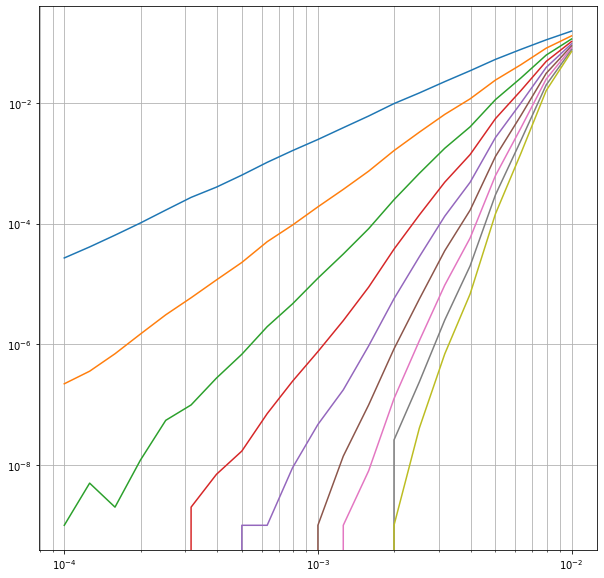

In [4]:
probs0 = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[15, 17, 19]-[3, 3, 3]-0.01-0.001-11-10000000- %2 fixes_atempt1.pickle", "rb"))
probs1 = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[15, 17, 19]-[3, 3, 3]-0.005011872336272725-0.001-8-100000000- %2 fixes_atempt1.pickle", "rb"))
probs2 = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[15, 17, 19]-[3, 3, 3]-0.003981071705534973-0.001-7-1000000000- %2 fixes_atempt1.pickle", "rb"))
probs3 = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[3, 5, 7, 9, 11, 13]-[3, 3, 3, 3, 3, 3]-0.01-0.0001-21-1000000000- %2 fixes_atempt1.pickle", "rb"))

start = 1E-2
stop = 1E-4
steps = 21
count = 100000
n_samples_loop = 10000
distances_x = [3, 5, 7, 9, 11, 13,15,17,19]
#distances_x = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37]
#distances_x = distances_z
distances_z = [3 for x in distances_x]

a0 = np.array(probs0)
b0 = np.transpose(a0, [2,0,1])
a1 = np.array(probs1)
b1 = np.transpose(a1, [2,0,1])
a2 = np.array(probs2)
b2 = np.transpose(a2, [2,0,1])
arr = np.concatenate((b0[0:3],b1[0:1],b2))
probs4 = np.transpose(arr, [1,2,0]).tolist()
probs3b = np.array(probs3).tolist()
probs = probs3b + probs4


plt.rcParams["figure.figsize"] = (10,10)
x = np.array([1.0E-2,4.7E-3, 2.2E-3, 1.0E-3])
y = x
#plt.loglog(x,y)
for i in range(len(probs)):
    d = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37][i]
    s = probs[i]
    x = np.array(s[0])
    y = np.array(s[1])
    plt.loglog(x, y)
plt.grid(True, which="both", ls="-")
#plt.show()
#plt.savefig(f"log mod2 - {str(distances_x)}-{str(distances_z)}-{start}-{stop}-{steps}-{count}.png", bbox_inches='tight')

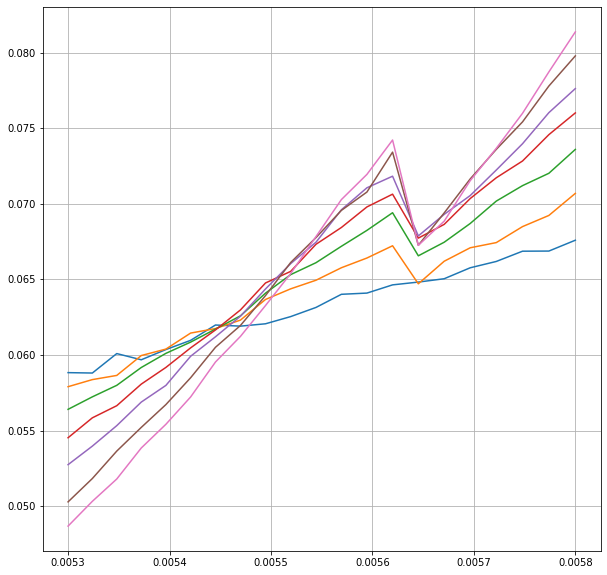

In [75]:
start = 5.3E-3
stop = 5.8E-3
steps = 21
count = 1000
n_samples_loop = 1000
probs = []
distances_x = [3,5,7,9,11,13]
#distances_x = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37]
distances_z= distances_x
#istances_z = [3 for x in distances_x]
lens = [x+2 for x in distances_x]
scales = [1 for x in distances_x]
#samples = [np.linspace(start, stop, steps) for x in distances_x]
samples = [np.geomspace(start, stop, steps) for x in distances_x]

probs = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[3, 5, 7, 9, 11, 13, 15]-[3, 5, 7, 9, 11, 13, 15]-0.0053-0.0058-21-1000000- %2 fixes_atempt1.pickle", "rb"))

plt.rcParams["figure.figsize"] = (10,10)
for i in range(len(probs)):
    d = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37][i]
    s = probs[i]
    x = np.array(s[0])
    y = np.array(s[1])
    plt.plot(x, y)
plt.grid(True, which="both", ls="-")
#plt.show()
plt.savefig(f"mod2 - {str(distances_x)}-{str(distances_z)}-{start}-{stop}-{steps}-{count}.png", bbox_inches='tight')

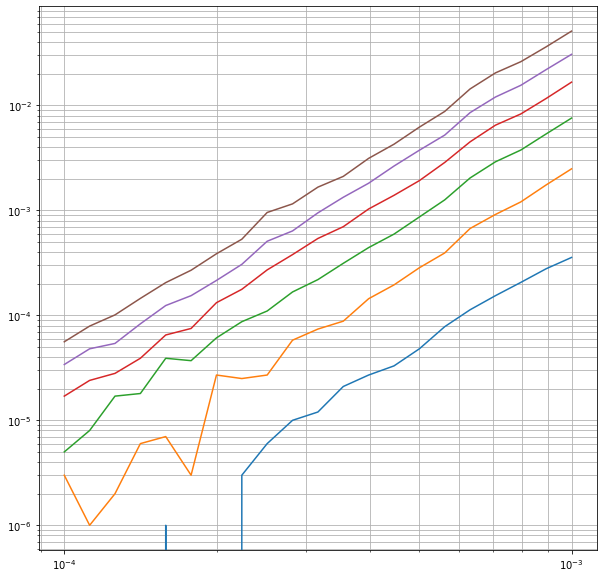

In [30]:
start = 1E-4
stop = 1E-3
steps = 21
count = 1000
n_samples_loop = 1000
probs = []
distances_z = [3,5,7,9,11,13,15,17,19,21]
#distances_x = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37]
#distances_z= distances_x
distances_x = [5 for x in distances_x]
lens = [x*x+2 for x in distances_z]
scales = [1 for x in distances_x]
#samples = [np.linspace(start, stop, steps) for x in distances_x]
samples = [np.geomspace(start, stop, steps) for x in distances_x]

probs = pickle.load(open("/home/atshaw/git/AlexisStuff/python_planar/[5, 5, 5, 5, 5, 5]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]-[11, 27, 51, 83, 123, 171, 227, 291, 363, 443]-0.0001-0.001-21-1000000- %2 fixes_atempt1.pickle", "rb"))

plt.rcParams["figure.figsize"] = (10,10)
for i in range(len(probs)):
    d = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37][i]
    s = probs[i]
    x = np.array(s[0])
    y = np.array(s[1])
    plt.loglog(x, y)
plt.grid(True, which="both", ls="-")
#plt.show()
plt.savefig(f"mod2 - {str(distances_x)}-{str(distances_z)}-{str(lens)}-{start}-{stop}-{steps}-{count}.png", bbox_inches='tight')

In [58]:
print(probs3b.tolist()[0])

[[0.01, 0.007943282347242814, 0.00630957344480193, 0.005011872336272725, 0.003981071705534973, 0.0031622776601683794, 0.0025118864315095794, 0.001995262314968879, 0.001584893192461114, 0.0012589254117941675, 0.001, 0.0007943282347242813, 0.000630957344480193, 0.0005011872336272725, 0.0003981071705534969, 0.00031622776601683794, 0.00025118864315095795, 0.00019952623149688788, 0.00015848931924611142, 0.0001258925411794166, 0.0001], [0.15651330600000005, 0.11211406200000003, 0.077820734, 0.053185835999999966, 0.03443770999999999, 0.022733109999999952, 0.01477488700000001, 0.009831574999999987, 0.0061158749999999954, 0.003916385999999994, 0.0024972860000000126, 0.0016337599999999858, 0.0010437609999999948, 0.0006405299999999784, 0.0004051299999999901, 0.00027384499999999343, 0.00016844599999999755, 0.00010289199999999882, 6.469199999999996e-05, 4.129400000000059e-05, 2.710200000000027e-05]]


In [12]:
np.arange(4E-3, 5E-3, 1E-4)

array([0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049])

In [14]:
def get_prob_from_measurements_z_b(final_measurements, corrections,dx, dz, n_samples):
    array = np.pad(final_measurements ^ corrections, ((0,0), (0, dx - 1)))
    print(array)
    array = array.reshape([n_samples, dz, 2*dx - 1])[:, :, :dx]
    print(array)
    array = array.sum(axis=1) % 2
    print(array)
    tallies = array.sum(axis = 1) % 2
    return tallies.sum()/n_samples

In [16]:
get_prob_from_measurements_z_b(np.array([[0,1,2,3,4,5,6,7,8,9,0xA,0xb,0xc]]), np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0]]), 3,3,1)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12  0  0]]
[[[ 0  1  2]
  [ 5  6  7]
  [10 11 12]]]
[[1 0 1]]


0.0

In [65]:
x_list = [3,5,7,9,11]
z_list = [3]

x_dims, z_dims, lens = np.transpose(np.array([[x_elem,z_elem, max(x_elem, z_elem)+2] for x_elem in x_list for z_elem in z_list])).tolist()

In [68]:
lens

[5, 7, 9, 11, 13]